Intalling Package

In [30]:
#%pip install python-binance
#%pip install numpy 
#%pip install pandas 
#%pip install matplotlib
#%pip install datetime 

In [1]:
import binance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta as td, datetime

In [2]:
def hodl(portfolio,early_balances):
    crypto_values = early_balances/portfolio[:1]
    balances = crypto_values.values * portfolio
    total_balances = balances.sum(axis=1)
    return total_balances,crypto_values

def rebalance(portfolio,crypto_values):
    asset_rebalance = []
    desire_balance = []
    total_rebalance = []
    weightss = []
    early_values = crypto_values.values
    for i in range(len(portfolio)):
        b = early_values * portfolio.values[i] # balance
        tb = np.sum(b) # total balance
        b_rebalance = np.asarray(weights) * tb # Balance Rebalance
        cv_rebalance = b_rebalance/portfolio.iloc[i] # Crypto Value After Rebalance
        desire = b_rebalance-b # Desire each asset
        desire_balance.append(desire.flatten()) 
        total_desire = np.sum(np.abs(desire))
        t_rebalance = np.sum(b_rebalance) - (total_desire*trading_fee)
        total_rebalance.append(t_rebalance) # Total balance after rebalance 
        early_values = cv_rebalance.values
        asset_rebalance.append(cv_rebalance)
        weightss.append(weights)
    total_rebalance = pd.DataFrame(total_rebalance).set_index(portfolio.index)
    desire_balance = pd.DataFrame(desire_balance, columns=portfolio.columns).set_index(portfolio.index)
    weightss =  pd.DataFrame(weightss).set_index(portfolio.index)
    return total_rebalance,asset_rebalance,desire_balance,weightss

def rebalance_wd(portfolio,crypto_values):
    asset_rebalance = []
    desire_balance = []
    total_rebalance = []
    early_values = crypto_values.values
    for i in range(len(portfolio)):
        b = early_values * portfolio.values[i] # balance
        tb = np.sum(b) # total balance
        b_rebalance = np.asarray(weights) * tb # Balance Rebalance
        cv_rebalance = b_rebalance/portfolio.iloc[i] # Crypto Value After Rebalance
        desire = b_rebalance-b # Desire each asset
        desire_balance.append(desire.flatten()) 
        total_desire = np.sum(np.abs(desire))
        t_rebalance = np.sum(b_rebalance) - (total_desire*trading_fee)
        if desire.all() > 10000:
            total_rebalance.append(t_rebalance) # Total balance after rebalance 
            early_values = cv_rebalance.values
            asset_rebalance.append(cv_rebalance)
        else:
            total_rebalance.append(np.sum(b_rebalance))
            early_values = early_values
            asset_rebalance.append(b)
    total_rebalance = pd.DataFrame(total_rebalance).set_index(portfolio.index)
    desire_balance = pd.DataFrame(desire_balance, columns=portfolio.columns).set_index(portfolio.index)
    return total_rebalance,asset_rebalance,desire_balance

# **Loading the data**
Kita ingin melatih pada data pasar cryptocurency (1 Bulan), dan di test dengan bulan berikutnya.

In [29]:
client = binance.Client()

tickers = ['ADAUSDT','HBARUSDT']
#date format month day year
startdate = '01-01-2020'
enddate = '02-16-2022'

columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Can be ignored']

crypto_data = {}
ndata=[]
for ticker in tickers:
    bars = client.get_historical_klines(ticker, client.KLINE_INTERVAL_1DAY, startdate, enddate)
    df = pd.DataFrame(bars, columns=columns)
    df = df.iloc[:,:6]
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index,unit="ms")
    df = df.astype("float")
    crypto_data[ticker] = df
    ndata.append(len(np.array(crypto_data[ticker].Close)))

portfolio = []
for ticker in tickers:
    portfolio.append(crypto_data[ticker].Close)
portfolio = pd.concat(portfolio, axis=1)
portfolio = portfolio.set_axis(axis=1,labels=tickers)
portfolio = portfolio.resample('W').last()    
    
d1 = datetime.strptime(startdate, '%m-%d-%Y')
d2 = datetime.strptime(enddate, '%m-%d-%Y')

def get_delta(d1, d2):
    delta = d2 - d1
    return delta

delta = get_delta(d1,d2)
print(delta)
print(ndata)
portfolio.head()

777 days, 0:00:00
[778, 778]


,ADAUSDT,HBARUSDT
Date,,
2020-01-05,0.03460,0.01157
2020-01-12,0.03792,0.01095
2020-01-19,0.04200,0.01085
2020-01-26,0.04477,0.01164
2020-02-02,0.05570,0.01309


<Axes: xlabel='Date'>

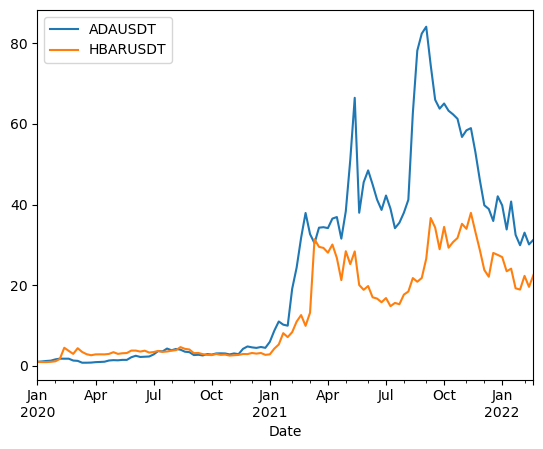

In [5]:
(portfolio/portfolio.iloc[0,:]).plot()

total early balance =  820001 $


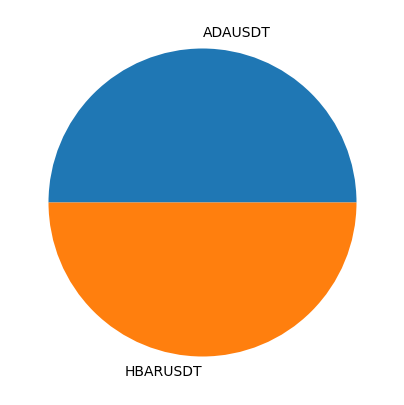

In [6]:
early_balances = [820000,1 ]
trading_fee = 0.03
total_early_balances = np.sum(early_balances)
print('total early balance = ', total_early_balances, '$')
resulta = []
for i in range(len(ndata)):
    resulta += [1/len(ndata)]
resulta
weights = resulta
total_weights = np.sum(weights)
if total_weights != 1.0:
    print('Error jumlah rasio harus 100%')
pd.Series(weights,tickers).plot.pie(figsize=(5,5));

<Axes: xlabel='Date'>

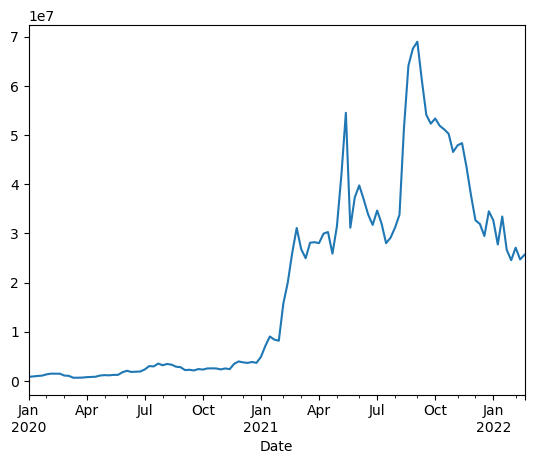

In [7]:
total_balances, crypto_values = hodl(portfolio,early_balances)
total_balances.plot()

<Axes: xlabel='Date'>

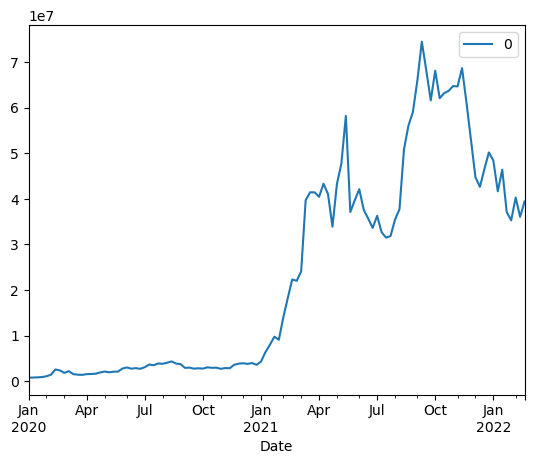

In [8]:
total_rebalance,asset_rebalance,desire_balance,weightss = rebalance(portfolio,crypto_values)
total_rebalance.plot()

In [9]:
desire_balance.head()

,ADAUSDT,HBARUSDT
Date,,
2020-01-05,-409999.500000,409999.500000
2020-01-12,-30655.864444,30655.864444
2020-01-19,-24436.038946,24436.038946
2020-01-26,1506.502485,-1506.502485
2020-02-02,-28084.762104,28084.762104


<Axes: xlabel='Date'>

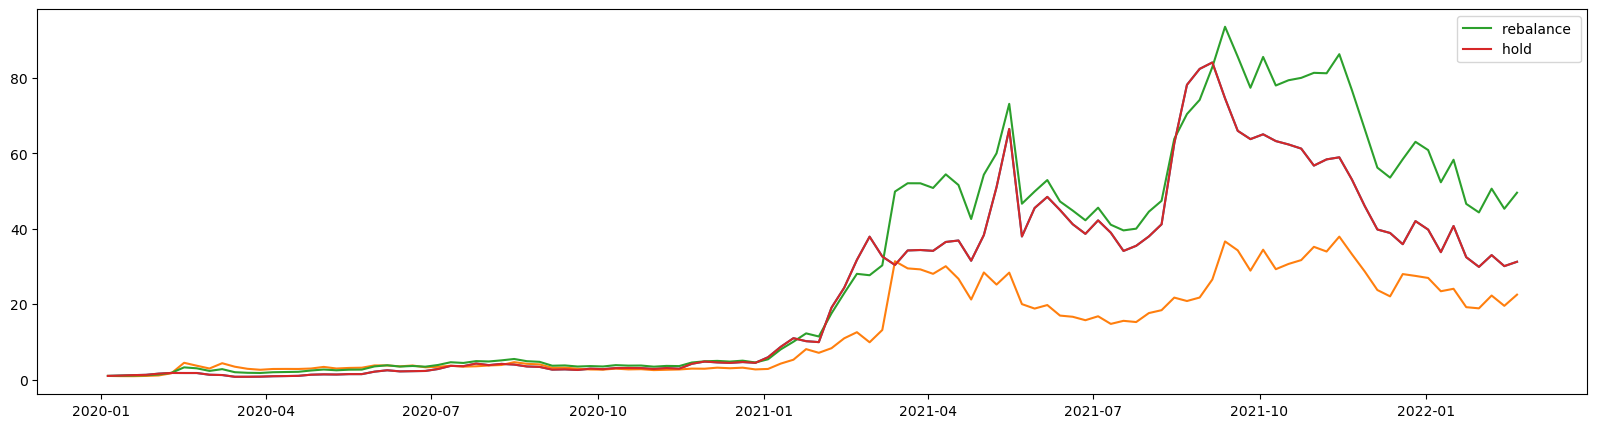

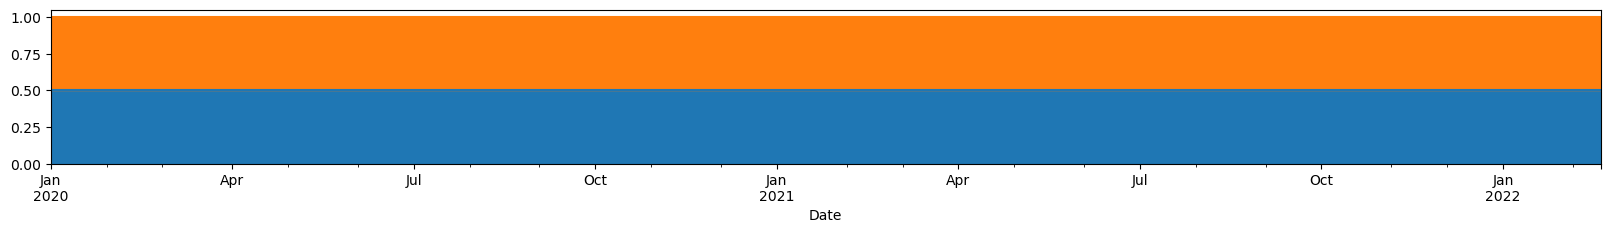

In [10]:
fig1 = plt.figure(figsize=(20,5))
ax1 = fig1.add_subplot(111)

ax1.plot((portfolio/portfolio.iloc[0,:]))
ax1.plot((total_rebalance/total_rebalance.iloc[0]),label='rebalance ')
ax1.plot((total_balances/total_balances.iloc[0]),label='hold ')
plt.legend()
weightss.plot.area(figsize=(20,2), legend=None)

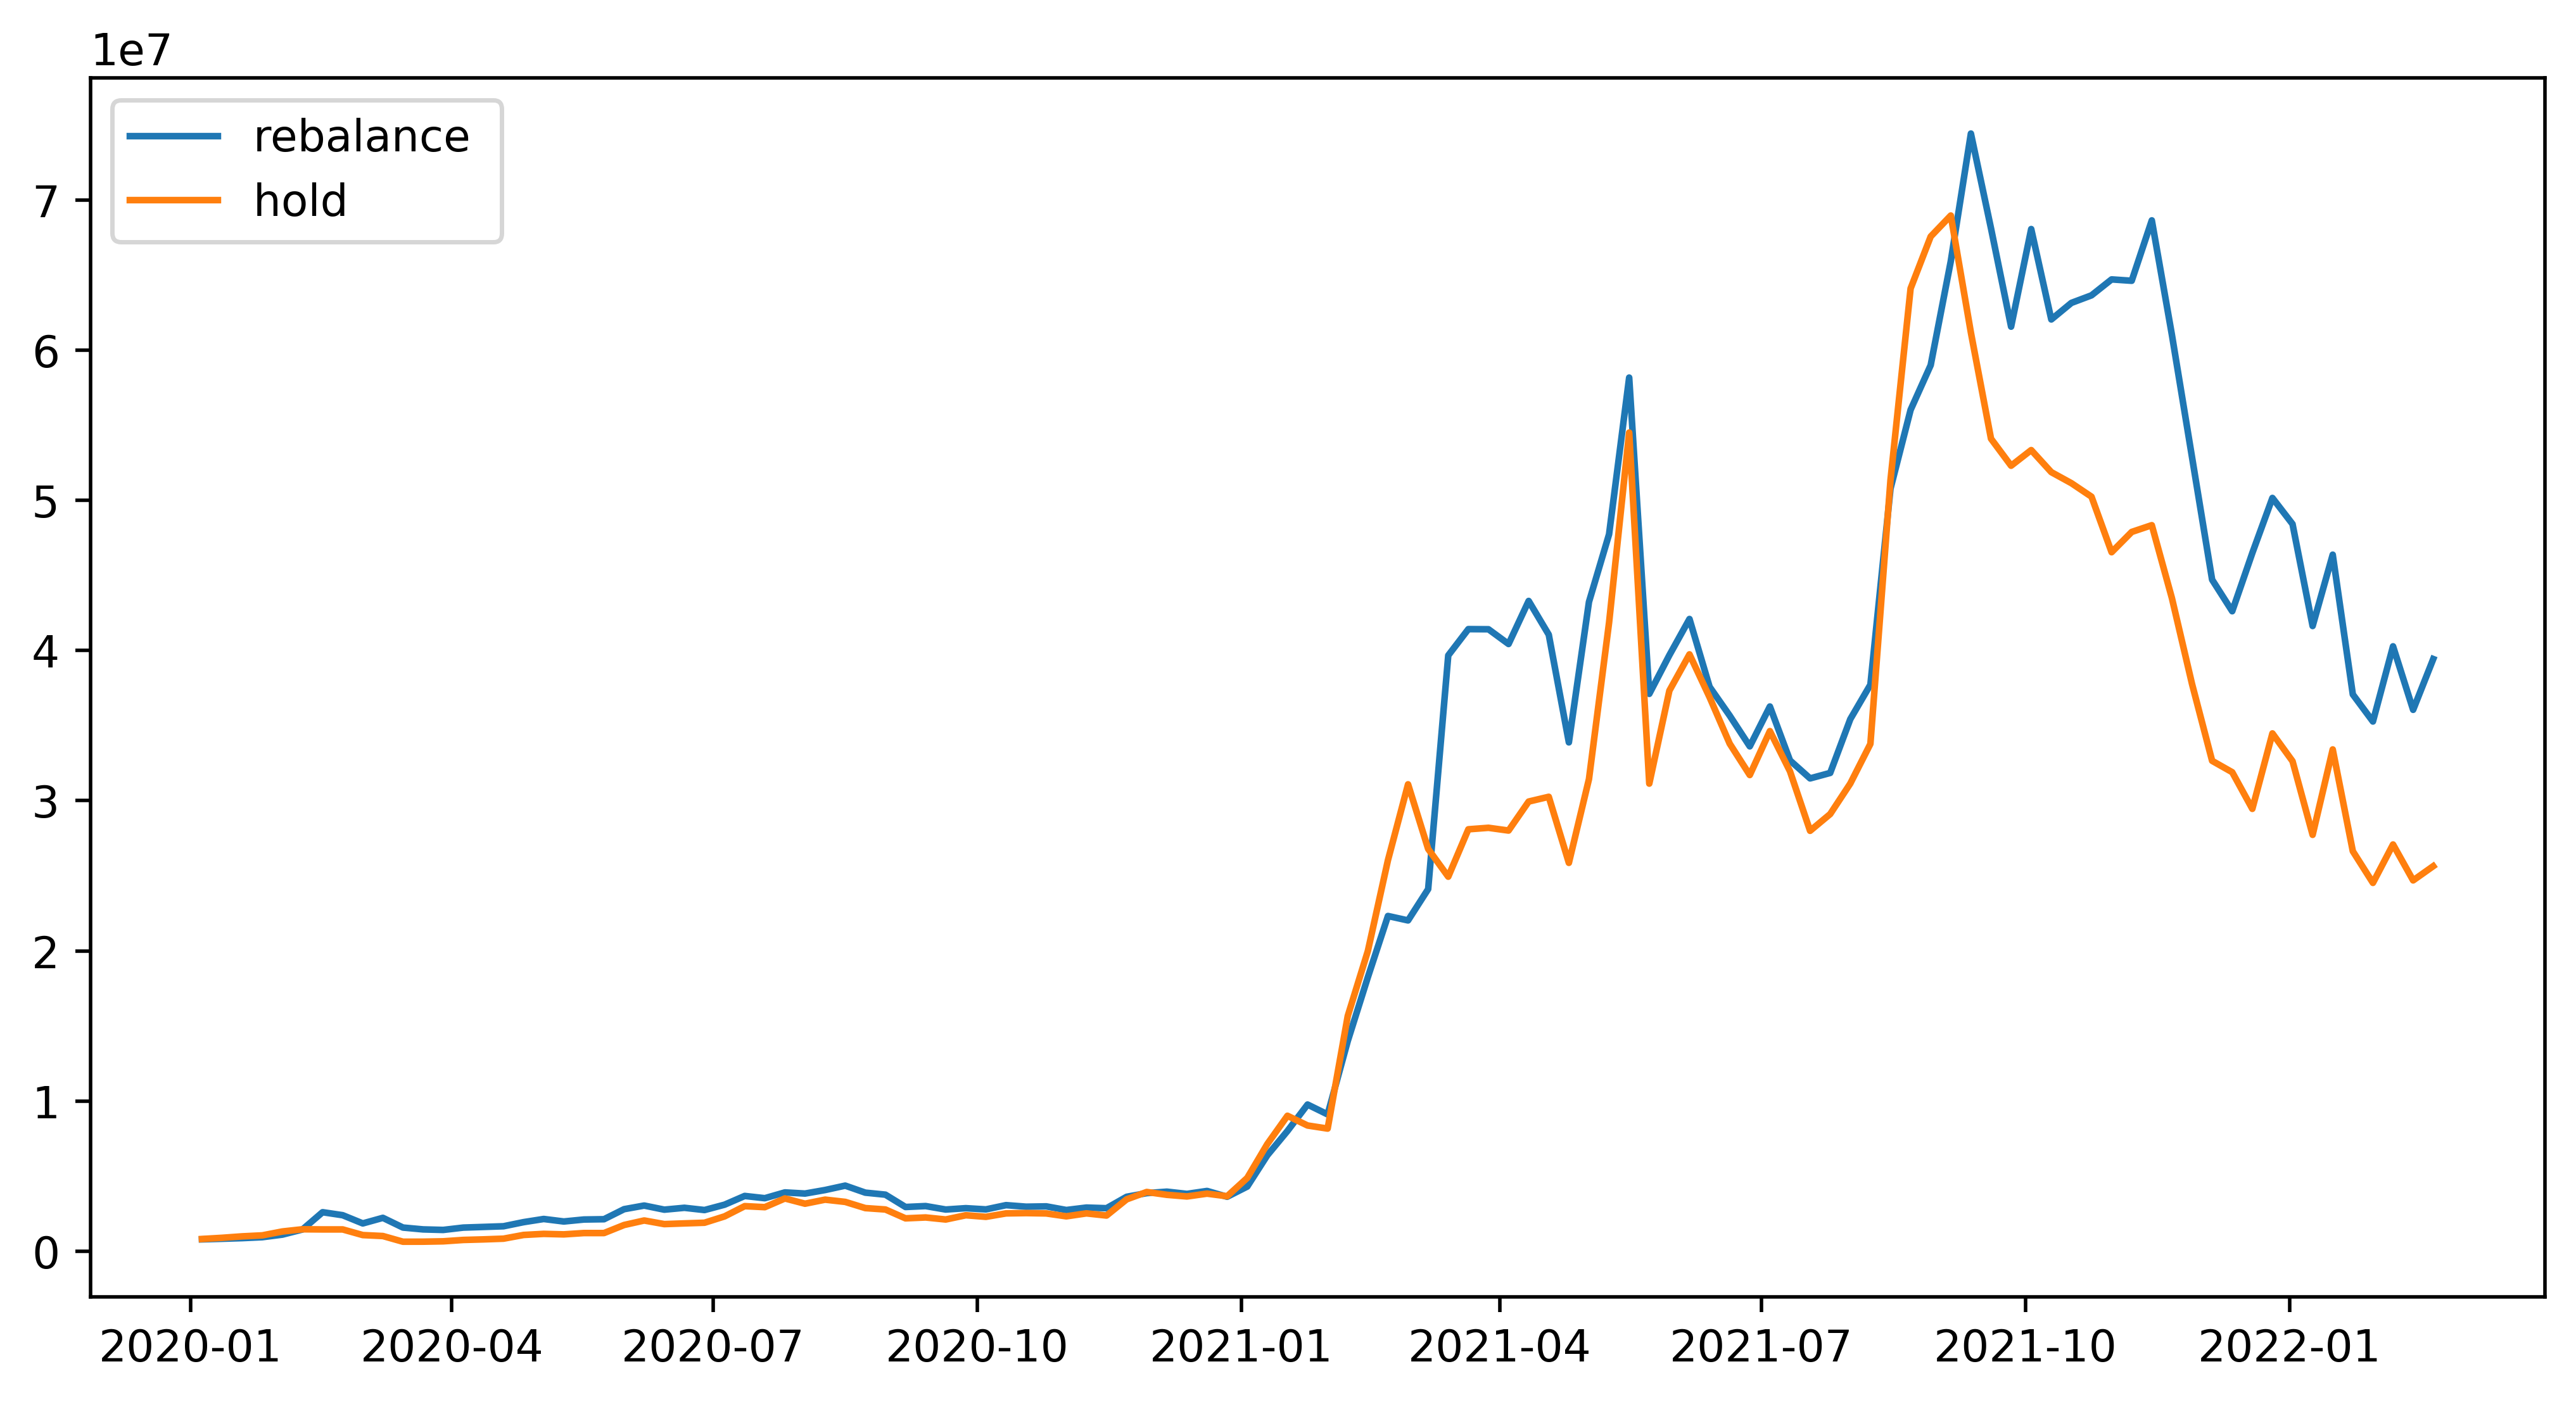

In [11]:
plt.figure(figsize=(10,5), dpi=500)
plt.plot(total_rebalance.index, total_rebalance.values,'-', label='rebalance ')
plt.plot(total_balances.index, total_balances.values,'-', label='hold ')
plt.legend()
plt.show()

## Return Rate
Return
The direct method to calculate the return or the holding period return $R$ over a single period of any length of time is:
$$R=\frac {V_f-V_i}{V_i}$$
$R$	=	return
$V_f$	=	final value, including dividends and interest
$V_i$	=	initial value

In [12]:
def return_rate(new_value,old_value):
    return 100*(new_value-old_value)/np.abs(old_value)

In [13]:
print('return rate Rebalance:',return_rate(total_rebalance.values.flatten()[-1],total_rebalance.values.flatten()[0])) #return rate rebalance
print('return rate HODL:',return_rate(total_balances.values[-1],total_balances.values[0])) #return rate Hodl
for i in tickers:
    print('return rate:',return_rate(portfolio[i][-1],portfolio[i][0]),i)

return rate Rebalance: 4857.814149421163
return rate HODL: 3027.166566403149
return rate: 3027.1676300578038 ADAUSDT
return rate: 2154.969749351772 HBARUSDT


C:\Users\Rozan\AppData\Local\Temp\ipykernel_8816\799679212.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('return rate:',return_rate(portfolio[i][-1],portfolio[i][0]),i)


## Staking ADA rate
The total accumulated value, including the principal sum P plus compounded interest I, is given by the formula:
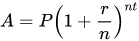
where:
A is the final amount
P is the original principal sum
r is the nominal annual interest rate
n is the compounding frequency
t is the overall length of time the interest is applied (expressed using the same time units as r, usually years).

In [14]:
startdt= portfolio.index[0]
enddt =  portfolio.index[-1]
times = len(pd.date_range(start=startdt,end=enddt,freq='Y'))
bada = 1*(1+0.05/1)**(1*times)
bada1=bada*portfolio['ADAUSDT'][-1]
bada0=portfolio['ADAUSDT'][0]
return_rate(bada1,bada0)

C:\Users\Rozan\AppData\Local\Temp\ipykernel_8816\3129576080.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bada1=bada*portfolio['ADAUSDT'][-1]
C:\Users\Rozan\AppData\Local\Temp\ipykernel_8816\3129576080.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bada0=portfolio['ADAUSDT'][0]


3347.7023121387288

# MPT

In [15]:
returns_portfolio = portfolio.pct_change()
returns_portfolio.head()

,ADAUSDT,HBARUSDT
Date,,
2020-01-05,NaN,NaN
2020-01-12,0.095954,-0.053587
2020-01-19,0.107595,-0.009132
2020-01-26,0.065952,0.072811
2020-02-02,0.244137,0.124570


In [16]:
weight_portfolio = weights
portfolio_return = returns_portfolio.dot(weight_portfolio)
portfolio_return.head()

Date
2020-01-05         NaN
2020-01-12    0.021183
2020-01-19    0.049231
2020-01-26    0.069382
2020-02-02    0.184354
Freq: W-SUN, dtype: float64

In [17]:
variance_matrix = returns_portfolio.cov()*356
variance_matrix

,ADAUSDT,HBARUSDT
ADAUSDT,11.678721,3.309433
HBARUSDT,3.309433,23.018457


In [18]:
# Computing portfolio variance
portfolio_variance = np.transpose(weight_portfolio)@variance_matrix@weight_portfolio

# Computing portfolio volatility (RISK)
portfolio_volatility = np.sqrt(portfolio_variance)

print("Portfolio Variance is",portfolio_variance)
print("Portfolio Volatility(Risk) is",portfolio_volatility)

Portfolio Variance is 10.329010948440864
Portfolio Volatility(Risk) is 3.21387786769206


In [19]:
port_returns = []
port_volatility = []
port_weights = []

num_assets = len(portfolio.columns)
num_portfolios = 10000

induvidual_rets = portfolio.resample('Y').last().pct_change().mean()

for port in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    port_weights.append(weights)
    returns = np.dot(weights, induvidual_rets)
    port_returns.append(returns)
    
    var = variance_matrix.mul(weights, axis = 0).mul(weights, axis = 1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(356)
    port_volatility.append(ann_sd)


In [20]:
data = {'Returns':port_returns, 'Volatility':port_volatility}

for counter, symbol in enumerate(portfolio.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in port_weights]
portfolios_V1 = pd.DataFrame(data)
portfolios_V1.head()

,Returns,Volatility,ADAUSDT weight,HBARUSDT weight
0,4.261678,60.652424,0.499607,0.500393
1,4.188145,57.181884,0.697120,0.302880
2,4.222765,58.009928,0.604127,0.395873
3,4.422659,85.420384,0.067205,0.932795
4,4.247427,59.485543,0.537887,0.462113


In [21]:
min_vol_port = portfolios_V1.iloc[portfolios_V1['Volatility'].idxmin()]
min_vol_port

Returns             4.186308
Volatility         57.179863
ADAUSDT weight      0.702052
HBARUSDT weight     0.297948
Name: 8209, dtype: float64

In [22]:
rf = 0.01
optimal_risky_port = portfolios_V1.iloc[((portfolios_V1['Returns']-rf)/portfolios_V1['Volatility']).idxmax()]
optimal_risky_port

Returns             4.197206
Volatility         57.254084
ADAUSDT weight      0.672781
HBARUSDT weight     0.327219
Name: 7433, dtype: float64

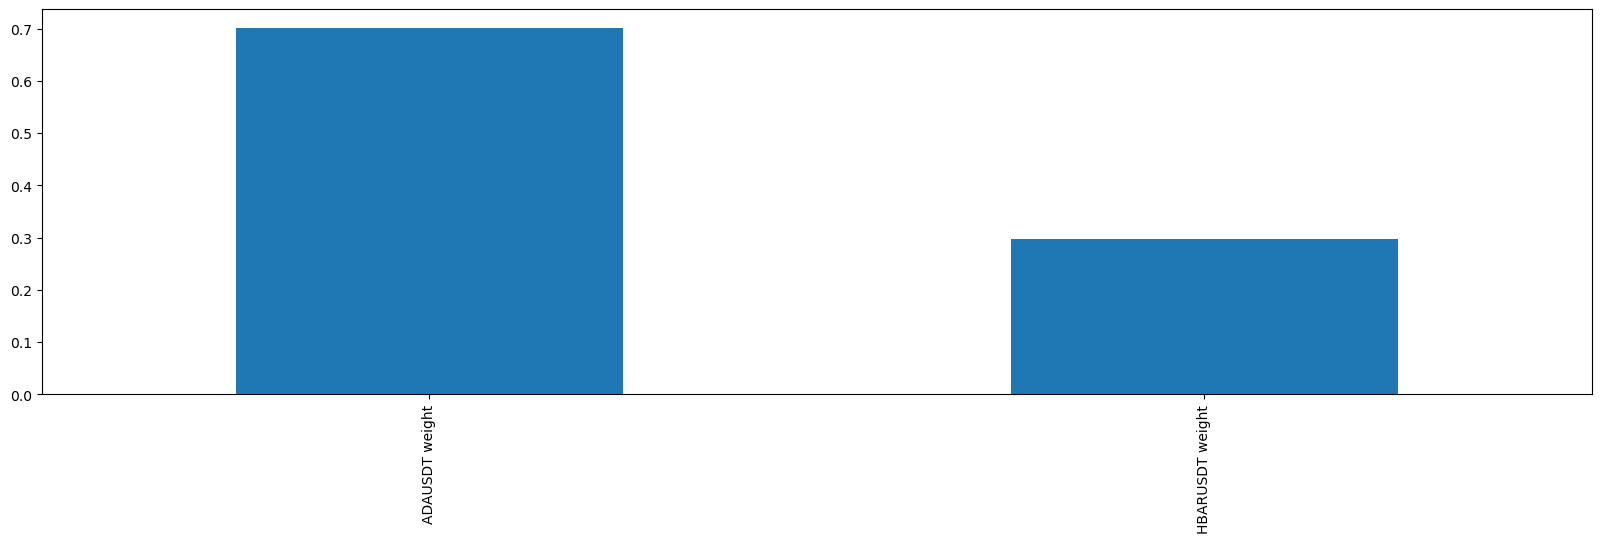

In [23]:
min_vol_port[2:99].plot.bar(figsize=(20,5));

<Axes: >

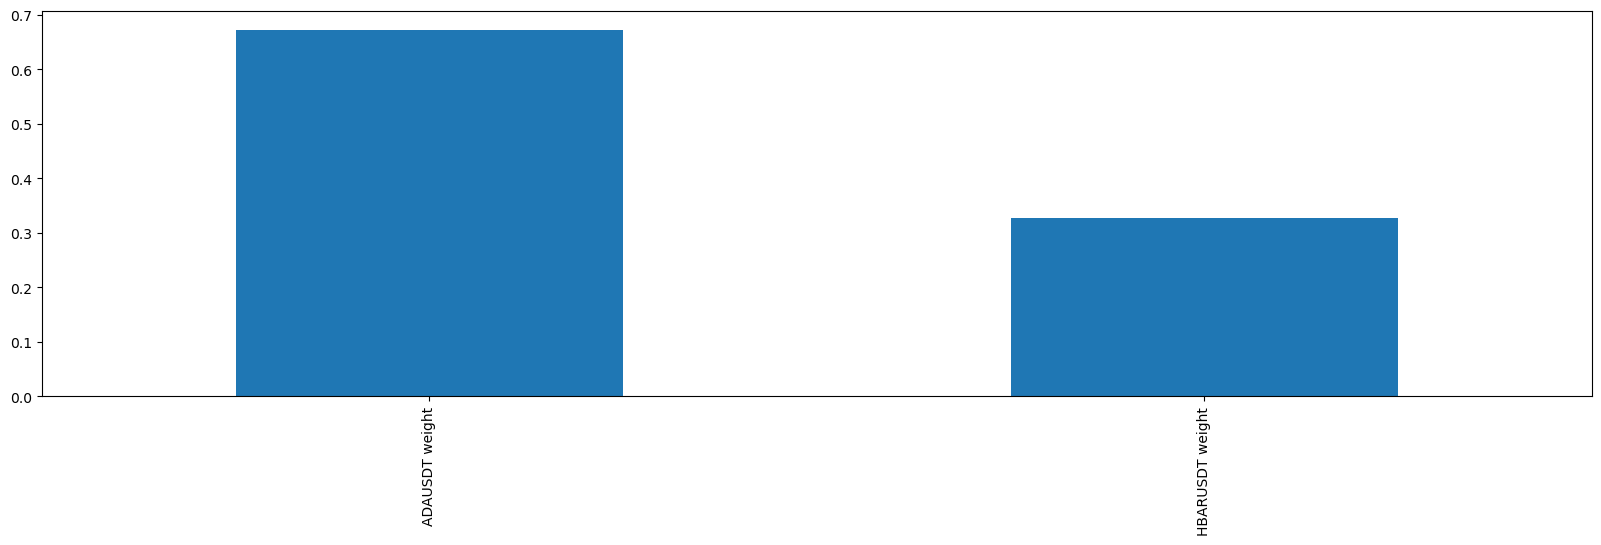

In [24]:
optimal_risky_port[2:99].plot.bar(figsize=(20,5))

In [25]:
optimal_risky_port[2:99].values 

array([0.67278083, 0.32721917])

In [26]:
min_vol_port[2:99].values 

array([0.70205199, 0.29794801])

portfolio.index.to_period('m').unique()

asset_rebalance = []
desire_balance = []
total_rebalance = []
for i in range(len(portfolio)):
    port_returns = []
    port_volatility = []
    port_weights = []

    num_assets = len(portfolio.columns)
    num_portfolios = 10

    induvidual_rets = portfolio.resample('D').last().pct_change().mean()

    for port in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        port_weights.append(weights)
        returns = np.dot(weights, induvidual_rets)
        port_returns.append(returns)

        var = variance_matrix.mul(weights, axis = 0).mul(weights, axis = 1).sum().sum()
        sd = np.sqrt(var)
        ann_sd = sd*np.sqrt(356)
        port_volatility.append(ann_sd)
    data = {'Returns':port_returns, 'Volatility':port_volatility}

    for counter, symbol in enumerate(portfolio.columns.tolist()):
        data[symbol+' weight'] = [w[counter] for w in port_weights]
    portfolios_V1 = pd.DataFrame(data)
    
    rf = 0.01
    optimal_risky_port = portfolios_V1.iloc[((portfolios_V1['Returns']-rf)/portfolios_V1['Volatility']).idxmax()]
    early_values = crypto_values.values
    b = early_values * portfolio.values[i] # balance
    tb = np.sum(b) # total balance
    b_rebalance = np.asarray(optimal_risky_port[2:99].values) * tb # Balance Rebalance
    cv_rebalance = b_rebalance/portfolio.iloc[i] # Crypto Value After Rebalance
    desire = b_rebalance-b # Desire each asset
    desire_balance.append(desire) 
    total_desire = np.sum(np.abs(desire))
    t_rebalance = np.sum(b_rebalance) - (total_desire*trading_fee)
    total_rebalance.append(t_rebalance) # Total balance after rebalance 
    #asset_rebalance.append(cv_rebalance)

total_rebalance = pd.DataFrame(total_rebalance).set_index(portfolio.index)


total_rebalance.plot()

plt.figure(figsize=(10,5), dpi=500)
plt.plot(total_rebalance.index, total_rebalance.values,'-', label='rebalance ', color='blue')
plt.plot(total_balances.index, total_balances.values,'-', label='hold ', color='grey')
plt.legend()
plt.show()

In [27]:
for i in range(len(portfolio)):
    tes = portfolio.values[i-1]+portfolio.values[i]

In [28]:
portfolio.values[0-1]

array([1.082 , 0.2609])